<a href="https://colab.research.google.com/github/mrm8488/shared_colab_notebooks/blob/master/IDEFICS_inference_adapter_captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tune IDEFICS for image captioning
> By [mrm8488](https://twitter.com/mrm8488) with the support of [CliBrAIn](https://clibrain.com/)

## IDEFICS: A Flamingo-based model, trained at scale for the community

<div style="text-align: center;">
</div>
<div style="display: flex; justify-content: center;">
    <img src="https://huggingface.co/HuggingFaceM4/idefics-80b/resolve/main/assets/Idefics_colab.png" alt="Idefics image" >
</div>

Credit: [Flamingo blog](https://www.deepmind.com/blog/tackling-multiple-tasks-with-a-single-visual-language-model)

[IDEFICS](https://huggingface.co/HuggingFaceM4/idefics-80b) is a multi-modal model based on the [Flamingo](https://arxiv.org/abs/2204.14198) architecture.

IDEFICS elegantly integrates two specialized, open-access pre-trained models to harmonize both visual and textual modalities. Sophisticated Transformer blocks serve as the newly instituted parameters, acting as the linchpin between the vision encoder and the linguistic model. This groundbreaking model is cultivated on a diverse training set, consisting of paired image-text instances as well as multifaceted multimedia web content.

The code for this notebook is heavily based on this [colab](https://github.com/huggingface/notebooks/blob/main/examples/idefics/finetune_image_captioning_peft.ipynb)

# Install and import necessary libraries

In [ ]:
! nvidia-smi

Fri Sep 22 20:49:45 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    47W / 350W |  19343MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install -q datasets
!pip install -q git+https://github.com/huggingface/transformers.git@add-model-idefics
!pip install -q bitsandbytes sentencepiece accelerate loralib
!pip install -q -U git+https://github.com/huggingface/peft.git

  error: subprocess-exited-with-error
  
  × git checkout -q add-model-idefics did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: subprocess-exited-with-error

× git checkout -q add-model-idefics did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
import torch
from datasets import load_dataset
from peft import LoraConfig, get_peft_model
from PIL import Image
from transformers import IdeficsForVisionText2Text, AutoProcessor, Trainer, TrainingArguments, BitsAndBytesConfig
import torchvision.transforms as transforms

# Load quantized model
First get the quantized version of the model. This will allow us to use the 9B version of Idefics with a single 16GB gpu



In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_id = "mrm8488/idefics-9b-ft-describe-diffusion-bf16"

In [ ]:
# Here we skip some special modules that can't be quantized properly
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    llm_int8_skip_modules=["lm_head", "embed_tokens"],
)

In [ ]:
from transformers import IdeficsForVisionText2Text, AutoProcessor
from peft import PeftModel, PeftConfig

peft_model_id = "mrm8488/idefics-9b-ft-describe-diffusion-bf16-adapter"
config = PeftConfig.from_pretrained(peft_model_id)
model = IdeficsForVisionText2Text.from_pretrained(config.base_model_name_or_path, torch_dtype=torch.bfloat16)
model = PeftModel.from_pretrained(model, peft_model_id)
processor = AutoProcessor.from_pretrained(config.base_model_name_or_path)
model = model.to(device)
model.eval()

Loading checkpoint shards:   0%|          | 0/19 [00:00<?, ?it/s]

PeftModel(
  (base_model): LoraModel(
    (model): IdeficsForVisionText2Text(
      (model): IdeficsModel(
        (embed_tokens): IdeficsDecoupledEmbedding(
          num_embeddings=32000, num_additional_embeddings=2, embedding_dim=4096, partially_freeze=False
          (additional_embedding): Embedding(2, 4096)
        )
        (vision_model): IdeficsVisionTransformer(
          (embeddings): IdeficsVisionEmbeddings(
            (patch_embedding): Conv2d(3, 1280, kernel_size=(14, 14), stride=(14, 14), bias=False)
            (position_embedding): Embedding(257, 1280)
          )
          (pre_layrnorm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
          (encoder): IdeficsVisionEncoder(
            (layers): ModuleList(
              (0-31): 32 x IdeficsVisionEncoderLayer(
                (self_attn): IdeficsVisionAttention(
                  (k_proj): Linear(
                    in_features=1280, out_features=1280, bias=True
                    (lora_dropout): ModuleD

In [ ]:
url = "https://framerusercontent.com/images/inZdRVn7eafZNvaVre2iW1a538.png" # https://cdn.arstechnica.net/wp-content/uploads/2023/06/zoomout_2-1440x807.jpg"
image = processor.image_processor.fetch_images(url)

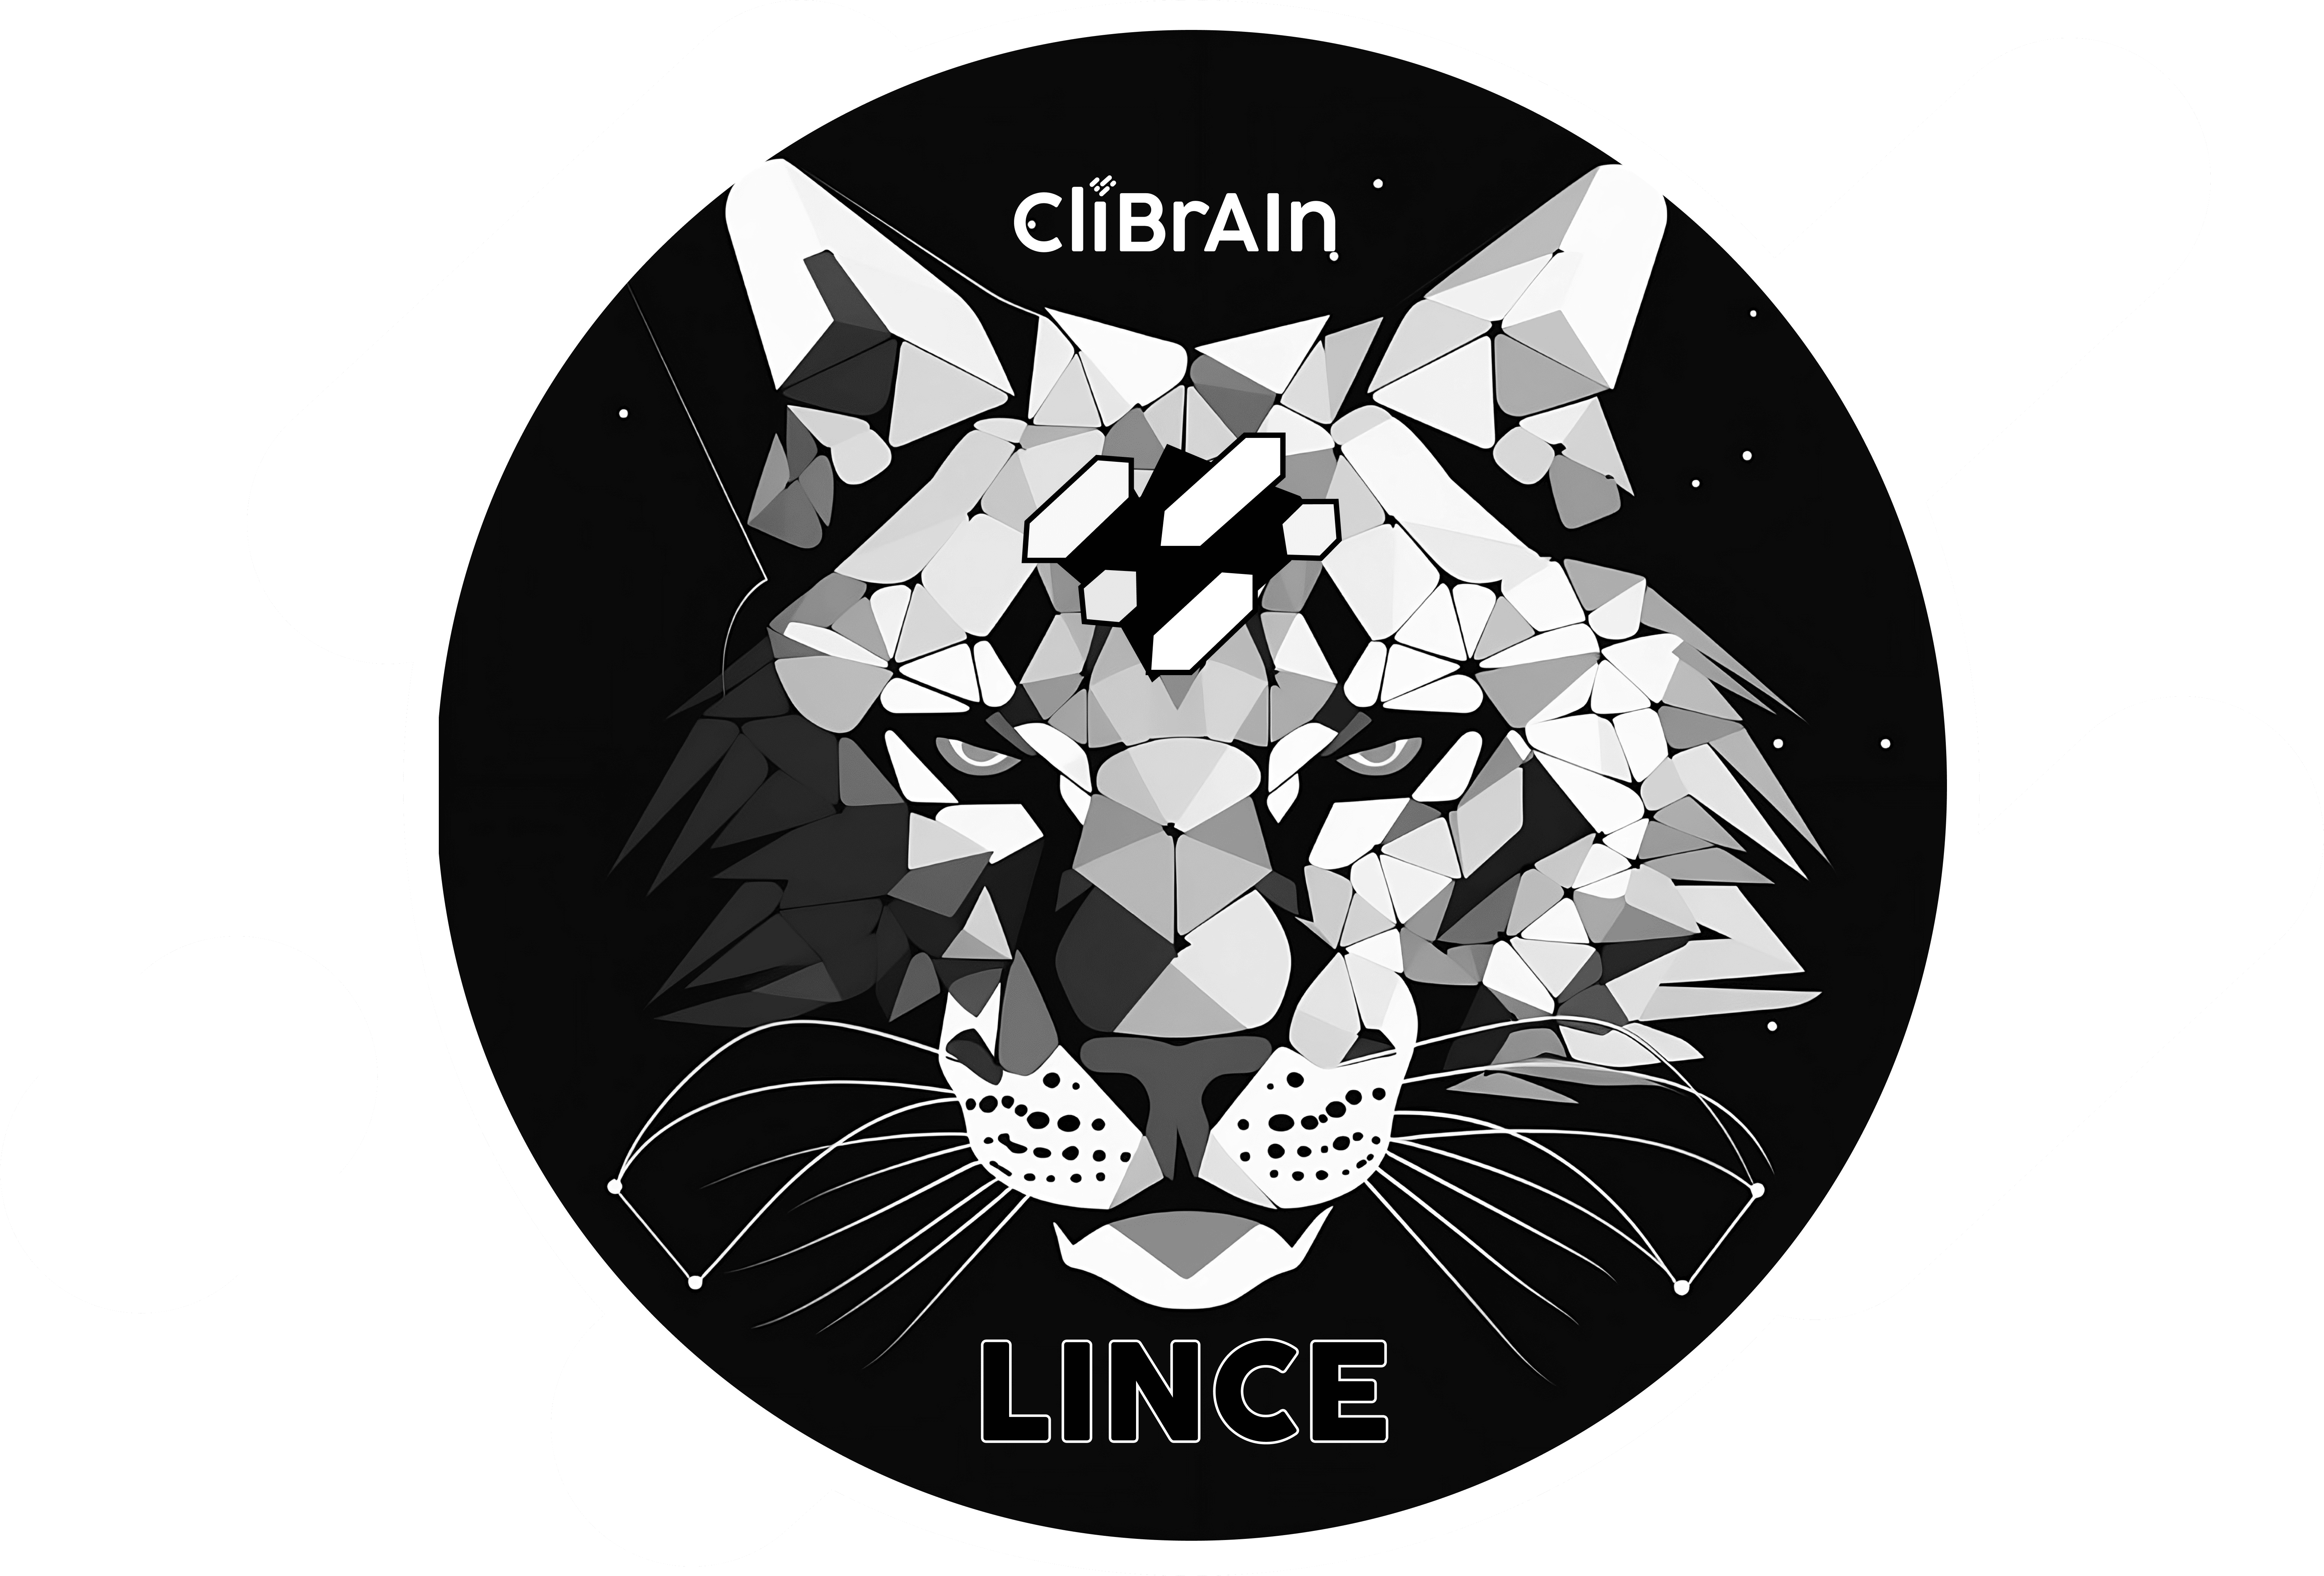

In [ ]:
image

In [ ]:
prompts = [
    [
        image,
        "Describe the following image:"
    ]
]

In [ ]:
inputs = processor(prompts[0], return_tensors="pt").to(device)

generated_ids = model.generate(**inputs, max_length=128)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_text)

Describe the following image: crypto logo, lynx, vector, white background, minimalistic, 
